<a href="https://colab.research.google.com/github/ani98622/NLP-assignments/blob/main/AniketMDS202308_Assignment_04%2605.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Name: Aniket Tiwari Assignment -04 & 05

### Assignment - 04

#### Block 0: Imports and NLTK Downloads

In [ ]:
import re
import json
import os
import shutil
import string
import numpy as np
from collections import Counter
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras import layers

# Download NLTK stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Block 1: Extracting Abstracts from JSON Files

In [ ]:
folder_path = '/content/drive/MyDrive/Assign/pdf_json/'
abstracts = []

def preprocess(text):
    text = text.strip().lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word)>2]
    return ' '.join(words)

def extract_abstracts_from_file(file_path):
    """Extract abstracts from a JSON file and preprocess them."""
    with open(file_path, 'r') as f:
        data = json.load(f)

        if "abstract" in data:
            for item in data['abstract']:
                if 'text' in item:
                    text = item['text']
                    processed_text = preprocess(text)
                    abstracts.append(processed_text)

for filename in os.listdir(folder_path):
    if filename.endswith(".json"):
        file_path = os.path.join(folder_path, filename)
        extract_abstracts_from_file(file_path)

with open('preprocessed.txt', 'w') as output_file:
    for abstract in abstracts:
        output_file.write(abstract + '\n')

#### Block 2: Building Vocabulary from processed abstracts and filter the corpus

In [ ]:
FILE_PATH = '/content/drive/MyDrive/Assign/extracted_abstracts.txt'
max_vocab_size = 10000
sentences = []

# Step 1: Read processed abstracts from the file
with open(FILE_PATH, 'r') as processed_file:
    sentences = processed_file.readlines()

# Step 2: Count word frequencies using Counter
word_counter = Counter()
for sentence in sentences:
    word_counter.update(sentence.strip().split())

# Step 3: Keep the most frequent `max_vocab_size` words
most_common_words = [word for word, _ in word_counter.most_common(max_vocab_size)]

# Step 4: Create a vocabulary dictionary with the most frequent words
vocab_dict = {word: i for i, word in enumerate(most_common_words)}

# Step 5: Filter sentences to only include words in the vocabulary
filtered_sentences = []
with open("filtered_sentences.txt", "w") as file:
    for sentence in sentences:
        filtered_sentence = [word for word in sentence.split() if word in vocab_dict]
        if filtered_sentence:
            file.write(" ".join(filtered_sentence) + "\n")
            filtered_sentences.append(filtered_sentence)

### Block 4: Imports and Model Definition

The following model is designed for word embedding tasks using TensorFlow/Keras. It consists of two main layers:

1. **Input Layer:**
   - Shape: `(vocab_count,)`
   - The input shape corresponds to the size of the vocabulary.

2. **Dense Layer (Embedding Layer):**
   - Units: `embedding_dim`
   - Activation: `linear`
   - This layer is used to project the input vocabulary into a dense vector space with the specified `embedding_dim`.

3. **Dense Layer (Output Layer):**
   - Units: `vocab_count`
   - Activation: `softmax`
   - This layer outputs a probability distribution over the entire vocabulary using the softmax activation function.

### Compilation:
- **Optimizer**: `SGD (Stochastic Gradient Descent)`
- **Loss Function**: `categorical_crossentropy`

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

def build_embedding_model(vocab_count, embedding_dim):
    embedding_net = tf.keras.Sequential([
        layers.Input(shape=(vocab_count,)),
        layers.Dense(embedding_dim, activation='linear'),  # Embedding layer
        layers.Dense(vocab_count, activation='softmax')  # Output layer
    ])

    embedding_net.compile(optimizer='sgd', loss='categorical_crossentropy')  # Using SGD for optimization
    return embedding_net

### Block 5: Model Parameters and Summary

In [ ]:
embedding_dimensions = 110
embedding_model = build_embedding_model(len(vocab_dict), embedding_dimensions)
embedding_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 110)            │     1,100,110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10000)          │     1,110,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,210,110 (8.43 MB)

 Trainable params: 2,210,110 (8.43 MB)

 Non-trainable params: 0 (0.00 B)

### Block 6: Generate Target-Context Pairs
This block contains a function to create target-context word pairs from the text corpus. For each target word in a sentence, we generate pairs based on a defined context window, which determines how many words around the target word are considered as context.

In [ ]:
def create_target_context_pairs(text_corpus, context_window=2):
    pairs = []

    for sentence in text_corpus:
        for position, target_word in enumerate(sentence):
            start_index = max(0, position - context_window)
            end_index = min(len(sentence), position + context_window + 1)

            for context_word in sentence[start_index:position] + sentence[position + 1:end_index]:
                pairs.append((target_word, context_word))
    return pairs

training_word_pairs = create_target_context_pairs(filtered_sentences)

### Block 7: Prepare Input and Output Data
In this block, we prepare the input and output data for training. We convert the target-context pairs into numerical indices using the vocabulary dictionary and print the shapes of the resulting arrays along with sample data.

In [ ]:
inputs, outputs = [], []

for target, context in training_word_pairs:
    inputs.append(vocab_dict[target])
    outputs.append(vocab_dict[context])

input_data = np.array(inputs)
output_data = np.array(outputs)

print("Input data shape:", input_data.shape)
print("Output data shape:", output_data.shape)
print("Sample Input:", input_data[50:55])
print("Sample Output:", output_data[50:55])

Input data shape: (18174288,)
Output data shape: (18174288,)
Sample Input: [1582 1582 1582    6    6]
Sample Output: [ 713    6 4921  713 1582]


### Block 8: One-Hot Encoding Function
This block defines a function that generates one-hot vectors for the input indices. Each index is transformed into a binary vector representing its position in the vocabulary.

In [ ]:
def generate_one_hot(index, total_vocab):
    one_hot_vector = np.zeros(total_vocab)
    one_hot_vector[index] = 1
    return one_hot_vector

### Block 9: Data Generator
This allows for efficient data loading in batches during model training by generating data `on-the-fly` to prevent `out of memory error`.


In [ ]:
def batch_data_generator(input_data, output_data, batch_size):
    total_samples = len(input_data)

    while True:
        for i in range(0, total_samples, batch_size):
            input_batch = input_data[i:i + batch_size]
            output_batch = output_data[i:i + batch_size]

            one_hot_inputs = np.array([generate_one_hot(index, max_vocab_size) for index in input_batch])
            one_hot_outputs = np.array([generate_one_hot(index, max_vocab_size) for index in output_batch])

            yield one_hot_inputs, one_hot_outputs

### Block 10: Model Training
Here, we train the skip-gram model using the training data generator. We specify the number of epochs and steps per epoch to control the training process.


In [ ]:
training_batch_size = 256

training_history = embedding_model.fit(
    batch_data_generator(input_data, output_data, training_batch_size),
    epochs=10,
    steps_per_epoch=len(input_data) // training_batch_size
)

Epoch 1/10
70993/70993 ━━━━━━━━━━━━━━━━━━━━ 1181s 17ms/step - loss: 8.5905
Epoch 2/10
70993/70993 ━━━━━━━━━━━━━━━━━━━━ 1163s 16ms/step - loss: 7.9450
Epoch 3/10
70993/70993 ━━━━━━━━━━━━━━━━━━━━ 1169s 16ms/step - loss: 7.9428
Epoch 4/10
70993/70993 ━━━━━━━━━━━━━━━━━━━━ 1167s 16ms/step - loss: 7.9417
Epoch 5/10
70993/70993 ━━━━━━━━━━━━━━━━━━━━ 1157s 16ms/step - loss: 7.9405
Epoch 6/10
70993/70993 ━━━━━━━━━━━━━━━━━━━━ 1168s 16ms/step - loss: 7.9381
Epoch 7/10
70993/70993 ━━━━━━━━━━━━━━━━━━━━ 1166s 16ms/step - loss: 7.9336
Epoch 8/10
70993/70993 ━━━━━━━━━━━━━━━━━━━━ 1154s 16ms/step - loss: 7.9267
Epoch 9/10
70993/70993 ━━━━━━━━━━━━━━━━━━━━ 1166s 16ms/step - loss: 7.9211
Epoch 10/10
70993/70993 ━━━━━━━━━━━━━━━━━━━━ 1163s 16ms/step - loss: 7.9167


### Block 11: Plot Training Loss
In this block, we visualize the training loss over the epochs. This plot helps us understand how the model's performance improves over time during training.


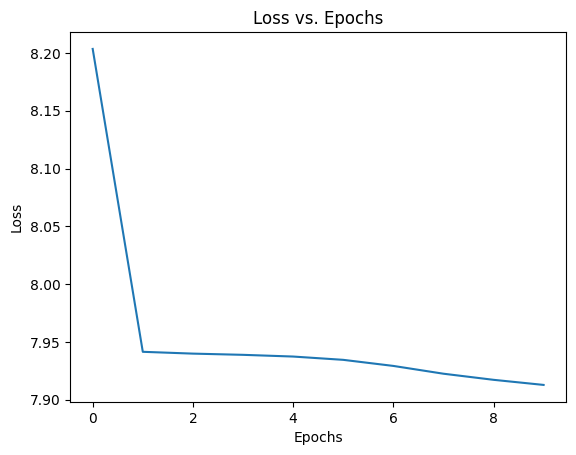

In [ ]:
plt.plot(training_history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.show()

#### Block 12 : Save the Model

In [ ]:
embedding_model.save('skipgram_model_raw_10_110.h5')
shutil.move('skipgram_model_raw_10_110.h5', '/content/drive/MyDrive/Assign/skipgram_model_raw_10_110.h5')

'/content/drive/MyDrive/Assign/skipgram_model_raw_10_110.h5' 


#### Block 12 : Checking Our Naive Skipgram Model

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def tokenize_corpus(vocab_dict):
    word_to_id = vocab_dict
    id_to_word = {id: word for word, id in word_to_id.items()}
    return list(vocab_dict.keys()), word_to_id, id_to_word

embedding_layer = embedding_model.layers[0]
word_embeddings = embedding_layer.get_weights()[0]
_,word_to_id,id_to_word = tokenize_corpus(vocab_dict)

def find_similar_words(word, top_n=5):
    word_idx = word_to_id[word]
    word_vector = word_embeddings[word_idx].reshape(1, -1)
    similarities = cosine_similarity(word_vector, word_embeddings)[0]
    similar_word_indices = similarities.argsort()[-top_n-1:-1][::-1]
    similar_words = [(id_to_word[idx], similarities[idx]) for idx in similar_word_indices]

    return similar_words

similar_words = find_similar_words('covid', top_n=12)
print([similar_word[0] for similar_word in similar_words])

['patient', 'hospitalized', 'global', 'reported', 'worldwide', 'admitted', 'outcome', 'control', 'affected', 'confirmed', 'admission', 'current']



### Implement Negative Sampling
### Block 0: Import libraries and define parameters

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

embed_size = 150
context_window = 2
neg_sample_count = 5
lr_rate = 0.05
epoch_count =200
batch_sz = 32

### Block 1: Building Training Pairs
This block defines the `build_training_pairs` function, which creates training pairs of target and context words based on the specified context window. For each target word, it identifies its surrounding context words and constructs pairs, which are then returned for training.

In [ ]:
def build_training_pairs(words_list, word_to_id, window_size):
    training_pairs = []
    for idx in range(window_size, len(words_list) - window_size):
        target_word = word_to_id[words_list[idx]]
        context_words = [word_to_id[words_list[idx - j - 1]] for j in range(window_size)]
        context_words += [word_to_id[words_list[idx + j + 1]] for j in range(window_size)]
        for ctx_word in context_words:
            training_pairs.append((target_word, ctx_word))
    return training_pairs

### Block 2: Generating Negative Samples
This block defines the `generate_negative_samples` function, which generates a set of negative samples for a given target word. The function ensures that the negative samples are distinct and do not include the target word itself.


In [ ]:
def generate_negative_samples(target_idx, neg_sample_count, vocab_sz):
    negative_samples = set()
    while len(negative_samples) < neg_sample_count:
        rand_sample = np.random.randint(0, vocab_sz)
        if rand_sample != target_idx:
            negative_samples.add(rand_sample)
    return list(negative_samples)

### Block 3: Dataset Class for Skip-Gram Model
This block defines the `SkipGramDataset` class, which inherits from `torch.utils.data.Dataset`. It provides methods to retrieve the number of training pairs and to access individual pairs by index. This class will be used to create a dataset for training the Skip-Gram model.


In [ ]:
class SkipGramDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.pairs[idx]

### Block 4: Skip-Gram Model Definition
This block defines the `SkipGramModel` class, which inherits from `nn.Module`. The model consists of two embedding layers (for target and context words) and uses a log-sigmoid function for computing scores. The `forward` method computes the positive and negative scores and calculates the total loss based on these scores, which will be used for training the model.

In [ ]:
class SkipGramModel(nn.Module):
    def __init__(self, vocab_sz, embed_size):
        super(SkipGramModel, self).__init__()
        self.target_embedding = nn.Embedding(vocab_sz, embed_size)
        self.context_embedding = nn.Embedding(vocab_sz, embed_size)
        self.log_sigmoid = nn.LogSigmoid()

    def forward(self, target_word, context_word, neg_samples):
        target_embed = self.target_embedding(target_word)
        context_embed = self.context_embedding(context_word)
        negative_embed = self.context_embedding(neg_samples)

        # Positive score
        pos_score = self.log_sigmoid(torch.sum(target_embed * context_embed, dim=1))
        # Negative score
        neg_score = self.log_sigmoid(-torch.bmm(negative_embed, target_embed.unsqueeze(2)).squeeze(2)).sum(1)

        # Loss calculation
        total_loss = - (pos_score + neg_score).mean()
        return total_loss

### Block 5 Preparing Data for Training
This block prepares the data for training. It tokenizes the filtered sentences to obtain individual words and their mappings, builds training pairs, and creates a dataset using the `SkipGramDataset` class. A `DataLoader` is used to enable batch processing.

In [ ]:
all_words, word_to_id, id_to_word = tokenize_corpus(vocab_dict)
train_pairs = build_training_pairs(all_words, word_to_id, context_window)

skipgram_dataset = SkipGramDataset(train_pairs)
data_loader = DataLoader(skipgram_dataset, batch_size=batch_sz, shuffle=True)

vocab_sz = len(word_to_id)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SkipGramModel(vocab_sz, embed_size).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr_rate)

### Block 6: Training Loop
This block contains the main training loop for the Skip-Gram model. It iterates over the specified number of epochs, processing each batch of training pairs. For each target-context pair, it generates negative samples, computes the loss using the model, and performs backpropagation to update the model parameters.

In [ ]:
losses = []
length = len(data_loader)
for epoch in range(epoch_count):
    epoch_loss = 0
    for target, context in data_loader:
        target = target.to(device)
        context = context.to(device)
        neg_samples = []

        for t_val in target:
            neg_samples.append(generate_negative_samples(t_val.item(), neg_sample_count, vocab_sz))

        neg_samples_tensor = torch.LongTensor(neg_samples).to(device)

        optimizer.zero_grad()
        loss = model(target, context, neg_samples_tensor)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    losses.append(epoch_loss/length)
    avg_loss = epoch_loss / length  # Average loss for the epoch
    print(f'Epoch [{epoch + 1}/{epoch_count}], Loss: {avg_loss:.4f}')

Epoch [1/200], Loss: 29.5812
Epoch [2/200], Loss: 29.0020
Epoch [3/200], Loss: 28.4896
Epoch [4/200], Loss: 28.1041
Epoch [5/200], Loss: 27.5860
Epoch [6/200], Loss: 27.0927
Epoch [7/200], Loss: 26.7898
Epoch [8/200], Loss: 26.5394
Epoch [9/200], Loss: 26.0492
Epoch [10/200], Loss: 25.7506
Epoch [11/200], Loss: 25.4564
Epoch [12/200], Loss: 25.0179
Epoch [13/200], Loss: 24.7414
Epoch [14/200], Loss: 24.5923
Epoch [15/200], Loss: 24.4305
Epoch [16/200], Loss: 24.0946
Epoch [17/200], Loss: 24.0080
Epoch [18/200], Loss: 23.6779
Epoch [19/200], Loss: 23.6290
Epoch [20/200], Loss: 23.5076
Epoch [21/200], Loss: 23.3245
Epoch [22/200], Loss: 23.1157
Epoch [23/200], Loss: 22.9841
Epoch [24/200], Loss: 22.6680
Epoch [25/200], Loss: 22.7894
Epoch [26/200], Loss: 22.6013
Epoch [27/200], Loss: 22.5444
Epoch [28/200], Loss: 22.4081
Epoch [29/200], Loss: 22.2561
Epoch [30/200], Loss: 22.2112
Epoch [31/200], Loss: 22.0862
Epoch [32/200], Loss: 21.9233
Epoch [33/200], Loss: 21.9268
Epoch [34/200], Los

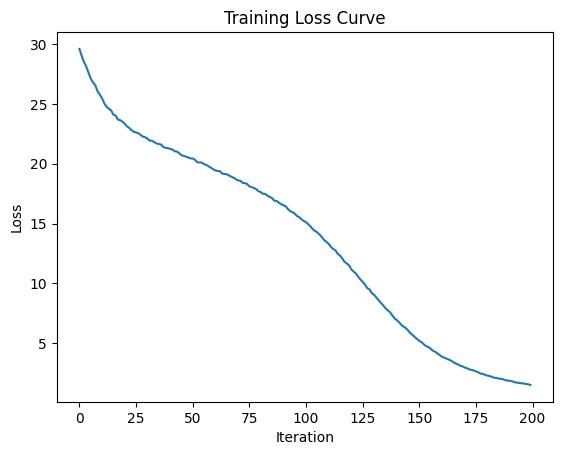

In [ ]:
# Plotting the loss curve
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

#### Testing the analogy
- By cosine similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def test_analogy_cosine(model, word_a, word_b, word_c):
    # Get the embeddings for the words
    vec_a = model.target_embedding.weight[word_to_id[word_a]].detach().cpu().numpy().reshape(1, -1)
    vec_b = model.target_embedding.weight[word_to_id[word_b]].detach().cpu().numpy().reshape(1, -1)
    vec_c = model.target_embedding.weight[word_to_id[word_c]].detach().cpu().numpy().reshape(1, -1)

    # Calculate the analogy vector
    analogy_vector = vec_b - vec_a + vec_c

    closest_word = None
    closest_similarity = -1

    for word, idx in word_to_id.items():
        vec_d = model.target_embedding.weight[idx].detach().cpu().numpy().reshape(1, -1)

        # Calculate cosine similarity
        similarity = cosine_similarity(analogy_vector, vec_d)[0][0]

        if similarity > closest_similarity and word not in [word_a, word_b, word_c]:
            closest_similarity = similarity
            closest_word = word

    return closest_word,closest_similarity

In [ ]:
# Test the analogy for COVID-19 related word pairs
analogies = [
    ("healthcare", "nurse", "doctor"),
    ("remote", "work", "online"),
    ("social", "distancing", "quarantine"),
    ("pandemic", "outbreak", "epidemic"),
]

def test_multiple_analogies(model, analogies):
    for word_a, word_b, word_c in analogies:
        predicted_word_d, closest_distance = test_analogy_cosine(model, word_a, word_b, word_c)
        print(f"{word_a} : {word_b} :: {word_c} : {predicted_word_d} (similarity score: {closest_distance:.4f})")

test_multiple_analogies(model, analogies)


healthcare : nurse :: doctor : physician (similarity score: 0.7910)
remote : work :: online : meetings (similarity score: 0.7583)
social : distancing :: quarantine : isolation (similarity score: 0.7441)
pandemic : outbreak :: epidemic : disease (similarity score: 0.739)



## Assignment - 05

#### Step 1: Find similar words Using $W_{in}$ (target_embeddings.weight)

In [ ]:
def for_W_in(model, word, top_n=5):
    word_vector = model.target_embedding.weight[word_to_id[word]].detach().cpu().numpy().reshape(1, -1)
    similar_words = []

    for vocab_word, idx in word_to_id.items():
        if vocab_word != word:
            vocab_word_vector = model.target_embedding.weight[idx].detach().cpu().numpy().reshape(1, -1)
            similarity = cosine_similarity(word_vector, vocab_word_vector)[0][0]
            similar_words.append((vocab_word, similarity))

    similar_words = sorted(similar_words, key=lambda x: x[1], reverse=True)[:top_n]

    return similar_words

similar_words = for_W_in(model, 'vaccine', top_n=6)
print([similar_word[0] for similar_word in similar_words])

['dose','booster','immunization','treatment','infertility','achievable']


#### Step 2: Find similar words Using $W_{out}$ (context_embedding.weight)



In [ ]:
def for_W_out(model, word, top_n=5):
    word_vector = model.context_embedding.weight[word_to_id[word]].detach().cpu().numpy().reshape(1, -1)
    similar_words = []

    for vocab_word, idx in word_to_id.items():
        if vocab_word != word:
            vocab_word_vector = model.context_embedding.weight[idx].detach().cpu().numpy().reshape(1, -1)
            similarity = cosine_similarity(word_vector, vocab_word_vector)[0][0]
            similar_words.append((vocab_word, similarity))

    similar_words = sorted(similar_words, key=lambda x: x[1], reverse=True)[:top_n]

    return similar_words

similar_words = for_W_out(model, 'vaccine', top_n=6)
print([similar_word[0] for similar_word in similar_words])

['covid','clinician','protection','pfizer','distribution','fatality']


#### Step 3: Find Similar Words Using Combined
##### Combine $W_{in}$ and $W_{out}$ : We will average the embeddings from both matrices

In [ ]:
def for_W_in_W_out_avg(model, word, top_n=5):
    # Get vectors from W_in and W_out and average them
    word_vector_in = model.target_embedding.weight[word_to_id[word]].detach().cpu().numpy()
    word_vector_out = model.context_embedding.weight[word_to_id[word]].detach().cpu().numpy()
    word_vector_avg = (word_vector_in + word_vector_out) / 2.0
    word_vector_avg = word_vector_avg.reshape(1, -1)

    similar_words = []

    for vocab_word, idx in word_to_id.items():
        if vocab_word != word:
            vocab_word_vector_in = model.target_embedding.weight[idx].detach().cpu().numpy()
            vocab_word_vector_out = model.context_embedding.weight[idx].detach().cpu().numpy()
            vocab_word_vector_avg = (vocab_word_vector_in + vocab_word_vector_out) / 2.0 # average the vectors
            vocab_word_vector_avg = vocab_word_vector_avg.reshape(1, -1)

            similarity = cosine_similarity(word_vector_avg, vocab_word_vector_avg)[0][0]
            similar_words.append((vocab_word, similarity))

    # Sort by similarity
    similar_words = sorted(similar_words, key=lambda x: x[1], reverse=True)[:top_n]

    return similar_words

similar_words_avg = for_W_in_W_out_avg(model, 'vaccine', top_n=7)
print([similar_word[0] for similar_word in similar_words])

['dose','covid','booster','achievable','distribution','choice','fatality']


#### Step 4: Compare the Results
##### In general :
- $W_{in}$ (Input Embeddings) focus on representing the word in the context of predicting other words (as a target).
- $W_{out}$ (Output Embeddings) focus on representing the word in the context of being predicted by other words (as a context word).
- In Other words,while $W_{in}$ captures how a word is used to predict surrounding words, $W_{out}$ captures how the surrounding words are used to predict the word.
- Combining $W_{in}$ and $W_{out}$ (through concatenation or averaging) creates a more holistic representation of the word. This embedding takes into account both how the word predicts and is predicted by its context.

##### With respect to the results :
- $W_{in}$ embeddings highlight how "vaccine" predicts surrounding words, focusing on grammatical and syntactic similarity. Similar terms include `dose`,`booster`,`immunization` etc.
- $W_{out}$ embeddings capture how "vaccine" is predicted by surrounding words, emphasizing associative and thematic context. Similar words include `covid`,`clinician`,`protection` etc.
- Combining $W_{in}$ and $W_{out}$ captures both contextual and thematic connections for "vaccine," merging functional terms like `dose` and broader associations like `covid` and `distribution`. This gives a more nuanced understanding of related words.

#### Step 5: Complexities of Skip-Gram Model we have implemented

1. **Building Training Pairs**:
   - For each word, the algorithm considers a context window of size $ C $, generating $ 2C $ training pairs.
   - **Complexity**: $ O(T \cdot C)\ $, where $ T $ is the number of words in the text corpus.

2. **Generating Negative Samples**:
   - For each target word, $ K $ negative samples are generated, ensuring they are distinct.
   - **Complexity**: $ O(K) $ per word.

3. **Forward Pass**:
   - For each training pair, the forward pass involves embedding lookups and calculating dot products.
   - **Complexity**: $ O((2C + K) \cdot N) $, where $ N $ is the embedding dimension.

4. **Training Loop**:
   - During each epoch, for each training pair, the model performs forward and backward passes.
   - **Total Complexity**: $ O(E \cdot T \cdot (2C + K) \cdot N) $, where $ E $ is the number of epochs.

#### Time Complexity of Analogy Task:

- **Vector Arithmetic**: $ O(N) $ (where $ N $ is the dimensionality of the embeddings).
- **Cosine Similarity**: $ O(V \cdot N) $ (for nearest neighbor search, where $ V $ is the vocabulary size and $ N $ is the dimensionality).

Thus, the overall time complexity of the analogy task is $ O(V \cdot N) $ , dominated by the cosine similarity calculation.
